# Credit Card Fraud Detection

Let's try and detect credit card frauds!

<img src="fig/credit_card_fraud.jpg">

This example is built starting from a dataset from the kaggle platform, you can find the original dataset [here](https://www.kaggle.com/mlg-ulb/creditcardfraud).

The datasets contains transactions made by credit cards in September 2013 by european cardholders in two days.

Given the size of the dataset (284,807 transactions), and since there since it is very unbalanced ("only" 492 frauds in two days), we selected a random sample of the normal transactions that we can easily work with. (You can find the code we used [here](src/creditcard/creditcard_subsamples.R))

Let's import the csv file and take a look!

In [1]:
source('src/lib.R')

In [2]:
# import the data
creditcard = read_csv('data/creditcard_15k.csv', col_types = cols())

## Let's have a look at the data

The data is composed of only numerical input variables (V1, V2, ... V28 are the result of a PCA transformation). Unfortunately, due to confidentiality issues, we do not have the original features and more background information about the data. The only original features are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount.

In [3]:
creditcard %>% head()

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
26,-0.5299123,0.87389158,1.34724733,0.1454567,0.41420886,0.10022309,0.71120608,0.176065957,-0.28671694,...,0.046949067,0.2081049,-0.18554835,0.00103066,0.0988157,-0.55290360,-0.073288084,0.02330704,6.14,0
34,-0.7622557,0.12776775,2.65005639,-1.8756628,-0.89335640,-0.26871489,-0.41986360,0.146233407,-0.86963529,...,0.433349642,1.2604027,-0.40470004,0.09494552,0.4809760,-0.09068468,0.319222973,0.13559993,15.99,0
49,0.9215437,-0.06708375,0.07746103,0.9536382,0.06741246,0.01615247,0.32045156,0.038534028,-0.39151266,...,-0.333929581,-1.2999196,0.08431099,-0.37039787,0.1551016,-0.83449036,0.000909065,0.03554688,135.51,0
51,1.2598731,0.25423958,0.51478863,0.6209243,-0.47593010,-0.99228584,0.06641651,-0.209275058,0.03557156,...,-0.256530536,-0.7392117,0.13573238,0.38198987,0.2193019,0.09429069,-0.028686668,0.01919759,1.98,0
53,-1.1989677,-1.47410047,1.84032599,-4.5158244,0.32756743,-0.17446928,0.95972570,-1.026456228,1.70043458,...,-0.453169417,0.3346140,-0.36454141,-0.31018578,-0.3025995,-1.24392415,-1.123456545,-0.73435109,89.17,0
111,-0.8208602,1.02256699,1.99656036,1.1801408,0.23246391,-0.12395255,0.68437085,-0.008256437,-0.57241030,...,0.000169258,0.1833824,-0.29991512,0.43180637,0.4567055,-0.21329820,-0.033160782,0.08837199,9.99,0


The column 'Class' is our label, it equals 1 in case of fraud and 0 otherwise:

In [4]:
creditcard %>% group_by(Class) %>%
  summarise(Transactions = n(), Average_Amount = mean(Amount))

Class,Transactions,Average_Amount
0,14508,89.88984
1,492,122.21132


We can take a look at the amounts:

Transactions,Average_Amount,Minimum_Amount,Maximum_Amount
15000,90.94998,0,10199.44


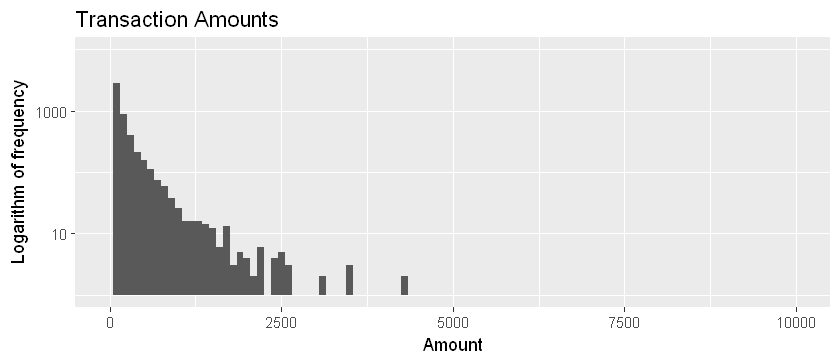

In [5]:
creditcard %>%
  summarise(Transactions = n(),
            Average_Amount = mean(Amount),
            Minimum_Amount = min(Amount),
            Maximum_Amount = max(Amount))

options(repr.plot.width=7, repr.plot.height=3)
creditcard %>%
  ggplot(aes(x = Amount)) + geom_histogram(binwidth = 100) + 
  labs(title='Transaction Amounts', y='Logarithm of frequency') +
  scale_y_log10() + xlim(c(0,10000)) #+ theme(legend.position = "none")

## Correlations

Let's calculate the Pearson correlation for the data.

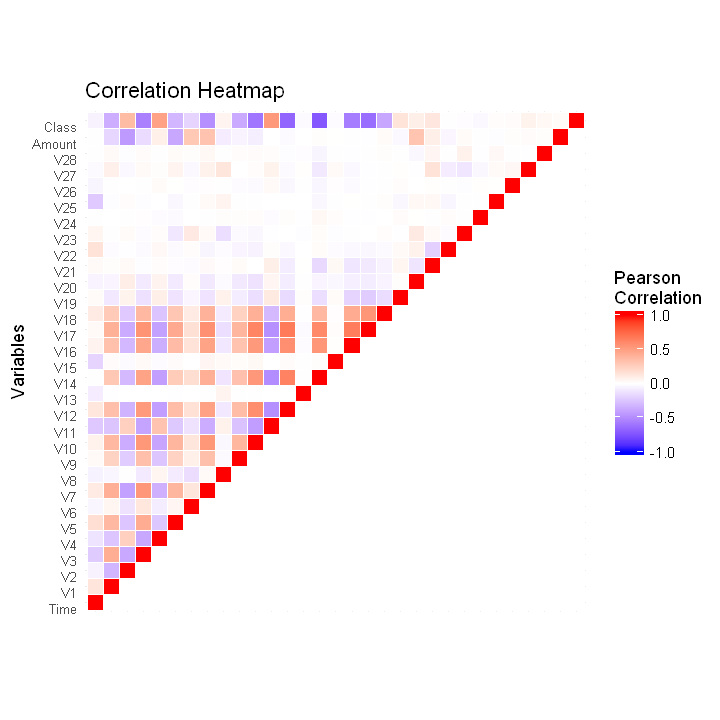

In [6]:
correlations = creditcard  %>% cor(use = "complete.obs", method = "pearson")

correlations[upper.tri(correlations)] = 0

correlations_gathered = as.data.frame(correlations) %>% 
  mutate(Var1 = factor(row.names(.), levels=row.names(.))) %>% 
  gather(key = Var2, value = value, -Var1, na.rm = TRUE, factor_key = TRUE) 

options(repr.plot.width=6, repr.plot.height=6)
ggplot(data = correlations_gathered, aes(Var2, Var1, fill = value)) + 
  geom_tile(color = "white")+
  scale_fill_gradient2(low = "blue", high = "red", mid = "white",
                       midpoint = 0, limit = c(-1,1), space = "Lab",
                       name="Pearson\nCorrelation") +
  theme_minimal() +
  theme(axis.text.y = element_text(angle = 0, vjust = 1,
                                   size = 8, hjust = 1),
        axis.text.x = element_blank()) + xlab("") + ylab('Variables') +
 ggtitle('Correlation Heatmap') +
 coord_fixed()

The features are mostly not correlated (because of the PCA algorithm).

## Pre-processing the data

In [7]:
## let's set up the features...
features =
    creditcard %>%
    select(Time, # select features
           V1:V28,
           Amount) %>% 
    mutate_if(is.character, fct_explicit_na) %>% # assign levels to missing obs
    mutate_all(as.numeric) %>% mutate_all(funs(replace(., is.na(.), 0))) %>% # set missing obs to 0
    mutate_all(scale) # normalize data

data = features

## and the labels
data$Class = creditcard$Class %>% recode('1' = 'Fraud', '0' = 'Normal') %>% factor

## Partitioning the data

Let's partition the dataset into training and testing subsamples.

In [8]:
set.seed(123)

partition = data %>% nrow %>% seq_len %>% createDataPartition(times = 1, p = 0.7, list = F)

train = data %>% slice(partition)
test = data %>% slice(-partition)

cat('train data size\n')
train %>% dim

cat('test data size\n')
test %>% dim

train data size


[1] 10500    31

test data size


[1] 4500   31

## Fitting a model

Let's try and fit a model!

In [9]:
cat('training started at')
Sys.time()

#####################
# Modify this part! #
#####################
model = train(x = train %>% select(-Class),
              y = train %>% pull(Class),
              method = 'kknn', ## how about a different model?
              ks = 5,  ## or different hyperparameters?
              trControl = trainControl(method = 'none', verboseIter = T)
)
#####################

cat('training finished at')
Sys.time()

cat('\nThis is the resulting model:\n')

model

training started at

[1] "2018-06-05 10:26:10 CEST"

Fitting kmax = 5, distance = 2, kernel = optimal on full training set
training finished at

[1] "2018-06-05 10:26:17 CEST"


This is the resulting model:


k-Nearest Neighbors 

10500 samples
   30 predictor
    2 classes: 'Fraud', 'Normal' 

No pre-processing
Resampling: None 

## How did we do?

In [10]:
test_response = model %>%
  predict(newdata = test %>% select(-Class))

confusionMatrix(test_response,
                test %>% pull(Class),
                positive = 'Fraud')

Confusion Matrix and Statistics

          Reference
Prediction Fraud Normal
    Fraud    139     16
    Normal    19   4326
                                          
               Accuracy : 0.9922          
                 95% CI : (0.9892, 0.9946)
    No Information Rate : 0.9649          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8842          
 Mcnemar's Test P-Value : 0.7353          
                                          
            Sensitivity : 0.87975         
            Specificity : 0.99632         
         Pos Pred Value : 0.89677         
         Neg Pred Value : 0.99563         
             Prevalence : 0.03511         
         Detection Rate : 0.03089         
   Detection Prevalence : 0.03444         
      Balanced Accuracy : 0.93803         
                                          
       'Positive' Class : Fraud           
                                          

## How did we really do?

Since fraud detection is so unbalanced toward normal transactions, we should use the AUROC as a measure of performance:

In [11]:
roc(test_response,
    test$Class) %>% 
    auc(.) %>% round(2)*2-1 %>% list('AR' = .) %>% unlist

AR 
0.88

## Now...

...go back and modify the code!

* How about different models/hyperparameters?
* Given a model, can you tune its hyperparameters?
* What about mixing two or three models with an ensamble?
* What is the highest AUROC you can get?